In [146]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns

from datetime import datetime

random_state = 42
np.random.seed(random_state)

In [147]:
# read the dataset
df = pd.read_csv('data/training_data.csv')
df

,timestamp,relation,train_number,delay,delay_cause
0,1667667583683,Szentendre - Batthyány tér,36H4001,0.740741,NaN
1,1667668572716,Batthyány tér - Szentendre,36H4008,0.095238,NaN
2,1667668696292,Szentendre - Batthyány tér,36H4011,0.444444,NaN
3,1667667830983,Batthyány tér - Szentendre,36H4012,3.000000,NaN
4,1667669806292,Batthyány tér - Szentendre,36H4018,0.333333,NaN
...,...,...,...,...,...
122119,1671354288630,Kecskemét - Budapest-Nyugati,552915,2.468354,Pálya állapota miatti késés
122120,1671035615214,Kőszeg - Szombathely,4339953,2.647059,NaN
122121,1671122465324,Kőszeg - Szombathely,4339953,3.714286,NaN
122122,1671208362253,Kőszeg - Szombathely,4339953,2.692308,NaN


In [148]:
# drop the delay column
df = df.drop(columns=['delay'])

# transform timestamp to hour
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x / 1000).hour)

# encode the non-numberic values
df['relation'] = df['relation'].apply(hash)
df['train_number'] = df['train_number'].apply(hash)
df['delay_cause'] = pd.Categorical(df['delay_cause']).codes

df

,timestamp,relation,train_number,delay_cause
0,16,2577223192884748813,8562292379348763782,-1
1,17,-883056363413438316,-4243257756989082374,-1
2,17,2577223192884748813,6515999940089911120,-1
3,17,-883056363413438316,7638260835581741274,-1
4,17,-883056363413438316,1045776363884299795,-1
...,...,...,...,...
122119,9,-2970080924197128546,-7208522902902085320,10
122120,16,1653831208084875386,-1072642874206649314,-1
122121,16,1653831208084875386,-1072642874206649314,-1
122122,16,1653831208084875386,-1072642874206649314,-1


In [149]:
# split the dataset into 80% training and 20% test set
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['delay_cause']), df.delay_cause, test_size=0.2, random_state=random_state)

# normalize the values
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [150]:
# create a random forest classifier model
model = RandomForestClassifier(n_estimators=10, verbose=2, random_state=random_state)

# train the model
history = model.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


In [151]:
# score the model between 0.0 and 1.0
score = model.score(X_test, Y_test)
score

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.8131422722620266

In [152]:
# predict delay casuses using the trained model
predictions = history.predict(X_test)

# create confusion matrix from true and predicted labels
conf = pd.crosstab(Y_test, predictions, margins=True, normalize=False)
conf = conf.apply(lambda column: column / column.iloc[len(column)-1], axis=1)

# drop the margin
conf = conf.drop(columns=['All'])
conf = conf.drop(conf.tail(1).index)

# show the confusion matrix
conf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


col_0,-1,0,1,2,3,4,5,6,7,10,11,12,13,16,18
delay_cause,,,,,,,,,,,,,,,
-1,0.959229,0.000000,0.000207,0.001137,0.000103,0.000207,0.000052,0.000000,0.000362,0.021496,0.000155,0.000103,0.004909,0.011937,0.000103
0,0.765957,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.085106,0.000000,0.000000,0.042553,0.085106,0.000000
1,0.716049,0.000000,0.004115,0.012346,0.000000,0.000000,0.000000,0.004115,0.000000,0.139918,0.000000,0.000000,0.028807,0.090535,0.004115
2,0.630769,0.000000,0.000000,0.064615,0.000000,0.003077,0.000000,0.000000,0.000000,0.221538,0.000000,0.000000,0.030769,0.046154,0.003077
3,0.789474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.052632,0.105263,0.000000
4,0.636364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.181818,0.000000
5,0.653846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230769,0.000000,0.000000,0.038462,0.076923,0.000000
6,0.937500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000
7,0.879310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.045977,0.005747


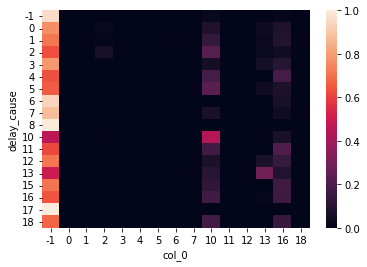

In [153]:
# show the heatmap
sns.heatmap(conf)